# MIDTERM ASSESSMENT_ BY ABDULSAMAD NURADEEN

**Predicting Housing Prices in Buenos Aires Project!**

## Import for this project

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from glob import glob
%matplotlib inline

# DATA CLEANING AND PREPARATION

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath)

  # Subset property in `"Capital Federal"`
  mask_ba = df['place_with_parent_names'].str.contains('Capital Federal')

  # Subset to apartment
  mask_apt = df['property_type'] == 'apartment'

  # Subset property where `"price appro usd"` < 400,000
  mask_price = df['price_aprox_usd'] < 400_000

  df = df[mask_ba & mask_apt & mask_price]

  # Remove outliers
  low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
  mask_area = df['surface_covered_in_m2'].between(low, high)
  df = df[mask_area]

  # Split "lat-lon" columns
  df[['lat', 'lon']] = df['lat-lon'].str.split(",", expand=True).astype(float)
  df.drop(columns=['lat-lon'], inplace=True)

  # Extract neighborhood
  df['neighborhood'] = df["place_with_parent_names"].str.split("|", expand=True)[3]
  df.drop(columns='place_with_parent_names', inplace=True)

  # drop feature with high null value
  df.drop(columns=['floor', 'expenses'], inplace=True)

  # drop low and high cardinaly columns
  df.drop(columns=['operation', 'property_type', 'properati_url', 'currency'], inplace=True)

  # drop leaky columns
  df.drop(
        columns=[
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
        ], inplace=True
    )

  # Drop multiple linear colinearity
  df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

  return df

In [ ]:
files = glob('/content/buenos-aires-real-estate-*.csv')
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print('df shapes: ', df.shape)
df.head()

df shapes:  (6582, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,215000.00,35.0,-34.588993,-58.400133,Recoleta
1,341550.00,90.0,-34.588044,-58.398066,Recoleta
2,91156.62,33.0,-34.623320,-58.397461,Monserrat
3,105000.00,33.0,-34.553897,-58.451939,Belgrano
4,89681.00,39.0,-34.628813,-58.472230,Villa del Parque


# EXPLORATORY DATA ANALYSIS(EDA)

**Distribution of Apartment Sizes**

Text(0.5, 1.0, 'Distribution of Apartment Sizes')

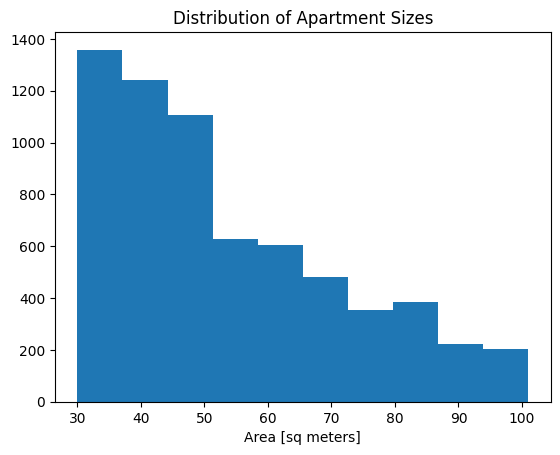

In [ ]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")

### The relationship between Area and Price

Text(0.5, 1.0, 'Buenos Aires: Area vs Price ')

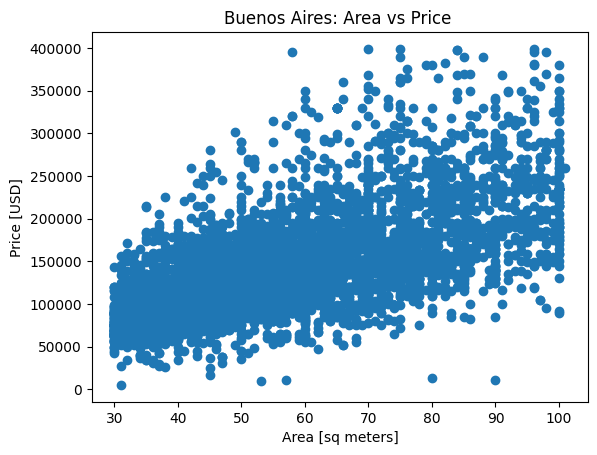

In [ ]:
plt.scatter(x=df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Buenos Aires: Area vs Price ')

### The relationship between Location and Price

In [ ]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat= "lat",
    lon= "lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color= "price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

# DATASET SPLITTING

In [ ]:
target = "price_aprox_usd"
y_train = df[target]
X_train = df.drop(columns=target)
X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,35.0,-34.588993,-58.400133,Recoleta
1,90.0,-34.588044,-58.398066,Recoleta
2,33.0,-34.623320,-58.397461,Monserrat
3,33.0,-34.553897,-58.451939,Belgrano
4,39.0,-34.628813,-58.472230,Villa del Parque


# DEVELOPING A MODEL

**Baseline model**

In [ ]:
y_mean = y_train.mean()
y_mean

np.float64(132383.83701458524)

In [ ]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:2]

[np.float64(132383.83701458524), np.float64(132383.83701458524)]

**Mean Absolute Error**

In [ ]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 132383.84
Baseline MAE: 44860.11


**Building a model**

In [ ]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

**Train a model**

In [ ]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([184979.62890175, 307926.90969065,  89663.11801875, 108306.14516346,
        91287.21260072])

**model evaluation**

In [ ]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 9572.54


**testing a model**

In [ ]:
X_test = pd.read_csv("/content/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

,0
0,186696.299747
1,158373.805610
2,79479.282464
3,49786.720801
4,99816.373116


# Communicate Results

**Coefficients and Intercepts**

In [ ]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data=data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [ ]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $127913.5'